<figure>
  <IMG SRC="https://upload.wikimedia.org/wikipedia/commons/thumb/d/d5/Fachhochschule_Südwestfalen_20xx_logo.svg/320px-Fachhochschule_Südwestfalen_20xx_logo.svg.png" WIDTH=250 ALIGN="right">
</figure>

# Machine Learning
### Sommersemester 2024
Prof. Dr. Heiner Giefers

# Entscheidungsbäume

Um die Funktionsweise von Entscheidungsbäumen und dem CART Algorithmus zu demonstrieren, verwenden wir ein einfaches Beispiel mit nur sehr wenigen Datenpunkten.
Bei den in der Code-Zelle unten angegebenen Wetterdaten `temperatur` und `niederschlag` handelt es sich um Monatsmittelwerte.
Der Datensatz hat also nur 12 Punkte.

Als Klassen assoziieren wir zu den Monaten je eine Jahreszeit.
Vereinfachend zählen wir die Monate Dezember bis Februar zum Winter, März bis Mai zum Frühling, u.s.w.

In [1]:
import numpy as np
temperatur = np.array([0.6,3.9,6.6,12.4,16.0,17.8,20.2,20.0,15.1,10.7,5.3,3.8])
niederschlag = np.array([72,30,75,35,50,50,40,35,45,28,30,80])

wetter_namen = ['Temperatur', 'Niederschlag']
wetter_label_names = np.array(['Winter', 'Frühling', 'Sommer', 'Herbst'])
wetter_label = np.array([0,0,1,1,1,2,2,2,3,3,3,0])
wetter_tabelle = np.column_stack((temperatur,niederschlag))

Nun können wir aus dem Modul `sklearn.tree` die Klasse `DecisionTreeClassifier` verwenden.

In [2]:
from sklearn.tree import DecisionTreeClassifier

wetter_tree = DecisionTreeClassifier(max_depth=30, random_state=12)
## max_depth bestimmt die Tiefe /Menge der Datenpunkte
# komplexe Modelle können bei kleinen Datensätzen zu Overfitting neigen
# sind die Daten komplex und die Tiefe nicht tief genug, führt das zu Underfitting
wetter_tree.fit(wetter_tabelle, wetter_label)

DecisionTreeClassifier(max_depth=30, random_state=12)

Für die Visualisierung des Entscheidungsbaumes verwenden wird die Funktion `plot_tree`.

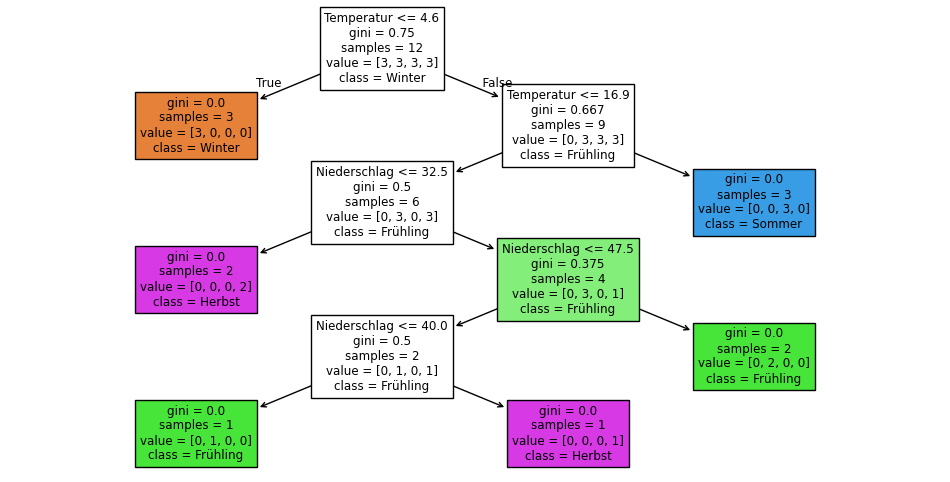

In [3]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
plt.figure(figsize=(12,6))
plot_tree(wetter_tree, filled=True, feature_names=wetter_namen, class_names=wetter_label_names);

Die Funktion `plot_regions` stellt die Entscheidungsgrenzen eines Modells mit zwei Attributen und bis zu fünf Klassen dar.

In [4]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
def plot_regions(X, model, labels, labelnames=None):
    if labelnames is None:
        labelnames = [i for i in np.unique(labels)]
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('gray', 'green', 'red', 'black', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(labels))])
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),np.arange(y_min, y_max, 0.1))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.4, cmap=plt.cm.RdBu)
    for idx, cl in enumerate(np.unique(labels)):
        plt.scatter(x=X[labels == cl, 0], y=X[labels == cl, 1],
                    alpha=0.8, c=[cmap(idx)],
                    marker=markers[idx], label=labelnames[cl])


Nun können wir darstellen, wie die Monate nach den Kriterien *Temperatur* und *Niederschlag* den 4 Jahreszeiten zugeordnet werden.

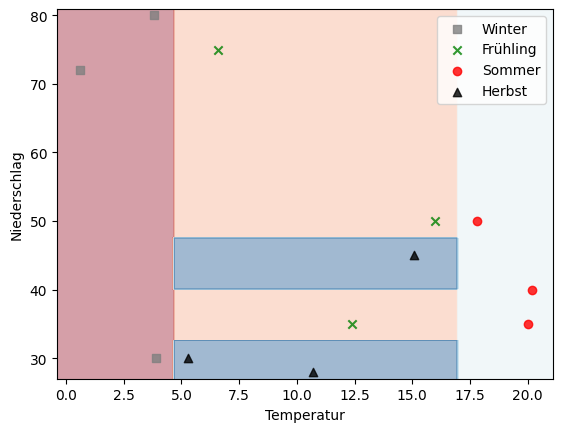

In [5]:
#plot_decision_regions(wetter_tabelle, wetter_label, classifier=wetter_tree, labelnames=wetter_label_names)
plot_regions(wetter_tabelle, wetter_tree, wetter_label, wetter_label_names)

plt.xlabel('Temperatur')
plt.ylabel('Niederschlag')
plt.legend(loc='upper right')
plt.show()

Was müssen Sie ändern, damit alle 12 Datenpunkte exakt eingeordnet werden? Was ist der Nachteil dieses Variante?

## Der CART Algorithmus

Für eine eigene Implementierung des CART Algorithmus fügen wir vorab die Datenpunkte und Labes zu einer Matrix zusammen.
Dies vereinfacht das Teilen der Datensätze (*split*) etwas.

In [6]:
data = np.column_stack((wetter_tabelle,wetter_label)) #Datenpunkte und Labes zu einer Matrix zusammen

Die *Reinheit* einer Menge von Datenpunkten berechnen wir über das *Gini-Maß*.
$$I_G=1-\sum_{i=1}^np_i^2$$

Die zugehörige Funktion `_gini` bestimmt zunächst die Menge der Labels.
In unserer Matrix stehen die Labels in der letzten Spalte `data[:,-1]`.
Da in einer Menge jeder Wert nur einmal enthalten sein kann sind in `c` nach der Operation je einmal die Werte 1-4 enthalten, mit denen die Jahreszeiten kodiert sind.

Für jede Jahreszeit bestimmen wir die Anzahl an Datenpunkten die zu dieser Jahreszeit gehören.
`d[:,-1]==cls` ist `True` für alle Zeilen der Matrix, die zu der Jahreszeit `cls` gehören.
Mit der Operation `d[d[:,-1]==cls]` Rrduzieren wir die Matrix auf die Zeilen für die Jahreszeit `cls` und bestimmen dann mit `len` ihre Länge in Zeilen.
Dieser Wert wird durch die Anzahl aller Datenpunkte `len(d)` geteilt.

In [7]:
data[tuple([data[:,-1]==1])]

array([[ 6.6, 75. ,  1. ],
       [12.4, 35. ,  1. ],
       [16. , 50. ,  1. ]])

In [8]:
def _gini(d):
    if len(d)==0: return 1;
    c = set(data[:,-1])
    g=1
    for cls in c:
        p=len(d[d[:,-1]==cls])/len(d)
        g -= p*p
    return g

# gini = 0 heißt, es gibt nur eine Klasse
# gini = 1 heißt, es ist absolut
# unique class labels c sind immer in der letzten Spalte der Matrix

Berechnen wir den *Gini-Wert* für die Ausgangsmenge, so erhalten wir das erwartete Resultat: $1-4\left(\frac{3}{12}\right)^2=1-0.25=0.75$

In [9]:
_gini(data)
'''
relativ hohe Ungleichverteilung oder Mischung der Klassen in den betrachteten Daten.
Es bedeutet, dass die Daten nicht homogen sind und viele unterschiedliche Klassen
gleichzeitig vertreten sind. Je näher der Gini-Wert an 1 liegt, desto höher ist die
Verteilung der Klassen, und je näher er an 0 ist, desto reiner ist die Verteilung
(alle Daten gehören zu einer einzigen Klasse)
'''

0.75

Die Funktion `_split` berechnet nun das Merkmal sowie die Bedingung an denen der Datensatz bestmöglich (d.h. mit maximalem Informationsgewinn) geteilt werden kann.
$$𝐼𝐺_𝐼(𝐷,𝑓)=𝐼(𝐷)−\sum_{𝐷_𝑖\in𝑓(𝐷)}\frac{|𝐷_𝑖|}{|𝐷|} 𝐼(𝐷_𝑖)$$

Dazu läuft die Funktion in einer äußeren Schleife über alle Merkmale, also über alle Spaltennummern, bis auf die letzte (dort stehen die Labels).
In jeder Spalte sortieren wir zunächst die Werte und bestimmen dann die möglichen Schnittpunkte.
Diese Schnittpunkte liegen immer genau zwischen zwei aufeinander folgenden Werten.
Mit `(last+i)/2` berechnen wir diesen Mittelwert und tragen in dann in die Liste `cuts` ein.

Anschließend läuft die Funktion über alle möglichen Schnittpunkte und wertet jeweils die Kostenfunktion für den Informationsgewinn aus.

Der global beste Wert und die das zugehörige Merkmal werden ermittelt und als Resultat zurückgegeben.

In [10]:
def _split(data):
    J_min=1               # 1 ist Maximum, sichere Inititalisierung
    best_val=0
    best_feature=0
    N_data = len(data)
    for feature in range(data.shape[1]-1):
        cuts = []
        f_sorted = np.sort(data[:,feature])
        last = f_sorted[0]
        for i in f_sorted[1:]:
            cuts.append((last+i)/2)
            last = i
        for val in cuts:
            true_set=data[data[:,feature]<=val]
            false_set=data[data[:,feature]>val]
            gini_t = _gini(true_set)
            gini_f = _gini(false_set)
            J = (gini_t*len(true_set)/N_data+gini_f*len(false_set)/N_data)
            if J<=J_min:
                J_min = J
                best_val = val
                best_feature=feature

    return best_feature,best_val

Die Funktion `_split` sollte nun in einer weiteren Funktion verwendet werden um den Entscheidungsbaum rekursiv aufzubauen.
Für unser einfaches Beispiel ist es aber ebensogut möglich, die Schritte des Algorithmus "per Hand" durchzuspielen.

Als ersten *Split* bestimmt die Funktion das Merkmal 0 (Temperatur) und den Wert 16.9.
Die Kinder dieses Splits haben die *Gini-Werte* 0.67 (Temperatur kleiner oder gleich 16.9) und 0 (Temperatur größer 16.9).
Damit wurde die Klasse der Sommermonate optimal abgedeckt.

Da nur der linke Teilbaum einen *Gini-Wert* größer 0 hat, muss nur das linke Kind expandiert werden.
Nun wird ebenfalls die Temperatur als Grundlage gewählt und die Wintermonate separiert.
Im letzten Split werden die Frühjahr- und Herbstmonate über die Niederschlagsmenge getrennt.

Der Entscheidungsbaum besitzt die selben Entscheidungsgrenzen, wie der von sklearn erzeugte.
Allerdings besitzen die beiden Bäume eine andere Struktur, da die sklearn-Version zunächst die Wintermonate abspaltet.
Dies hat ausschließlich mit der Reihenfolge der Berechnungen zu tun, das die *Gini-Werte* und Teilmengengrößen in beiden Fällen identisch sind.

In [11]:
best_feature,best_val = _split(data)
print("Split column", best_feature, "at", best_val)

left_set=data[data[:,best_feature]<best_val]
right_set=data[data[:,best_feature]>=best_val]
print("Gini left: %.2f | Gini right %.2f" % (_gini(left_set), _gini(right_set)))

best_feature,best_val = _split(left_set)
print("Split column", best_feature, "at", best_val)

left_set1=left_set[left_set[:,best_feature]<best_val]
right_set1=left_set[left_set[:,best_feature]>=best_val]
print("Gini left: %.2f | Gini right %.2f" % (_gini(left_set1), _gini(right_set1)))

best_feature,best_val = _split(right_set1)
print("Split column", best_feature, "at", best_val)

left_set2=right_set1[right_set1[:,best_feature]<best_val]
right_set2=right_set1[right_set1[:,best_feature]>=best_val]
print("Gini left: %.2f | Gini right %.2f" % (_gini(left_set2), _gini(right_set2)))

Split column 0 at 16.9
Gini left: 0.67 | Gini right 0.00
Split column 0 at 4.6
Gini left: 0.00 | Gini right 0.50
Split column 1 at 47.5
Gini left: 0.38 | Gini right 0.00


## Kreditvergabe mit Entscheidungsbäumen

In den folgenden Code-Zellen verwenden wir sklearn, um den aus dem letzten Arbeitsblatt bekannten Datensatz `kredit.csv` zu verarbeiten.
Statt mit logistischer Regression wollen wir nun *gute* und *schlechte* Kredite über einen Entscheidungsbaum und später über *Random Forests* zu klassifizieren.

Da die Schritte größtenteils selbsterklärend und aus vorherigen Beispielen bekannt sind, wird hier auf eine ausführliche Beschreibung verzichtet.

In [16]:
import pandas as pd
import urllib.request
import os

url = "https://raw.githubusercontent.com/fhswf/datasets/main/kredit.csv"
dfile = "./kredit.csv"

if not os.path.isfile(dfile):
    urllib.request.urlretrieve(url, dfile)
df = pd.read_csv(dfile)
df.head(10)

,kredit,laufkont,laufzeit,moral,verw,hoehe,sparkont,beszeit,rate,famges,...,wohnzeit,verm,alter,weitkred,wohn,bishkred,beruf,pers,telef,gastarb
0,1,1,18,4,2,1049,1,2,4,2,...,4,2,21,3,1,1,3,1,1,1
1,1,1,9,4,0,2799,1,3,2,3,...,2,1,36,3,1,2,3,2,1,1
2,1,2,12,2,9,841,2,4,2,2,...,4,1,23,3,1,1,2,1,1,1
3,1,1,12,4,0,2122,1,3,3,3,...,2,1,39,3,1,2,2,2,1,2
4,1,1,12,4,0,2171,1,3,4,3,...,4,2,38,1,2,2,2,1,1,2
5,1,1,10,4,0,2241,1,2,1,3,...,3,1,48,3,1,2,2,2,1,2
6,1,1,8,4,0,3398,1,4,1,3,...,4,1,39,3,2,2,2,1,1,2
7,1,1,6,4,0,1361,1,2,2,3,...,4,1,40,3,2,1,2,2,1,2
8,1,4,18,4,3,1098,1,1,4,2,...,4,3,65,3,2,2,1,1,1,1
9,1,2,24,2,3,3758,3,1,1,2,...,4,4,23,3,1,1,1,1,1,1


In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,1:],df.iloc[:,0],test_size=0.3, random_state=0)
#[:,1:] alle Zeilen und Spalten ab dem Index 1 werden X als features zugewiesen
# die alle Zeilen die erste Spalte wird als Label Y angegeben

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as img
import pydot
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import accuracy_score
%matplotlib inline

model = DecisionTreeClassifier(max_depth=3)
#model = DecisionTreeClassifier(criterion="entropy")
model.fit(X_train,y_train)


scr = model.score(X_test, y_test)
print("Die Vorhersagegenauigkeit des Entscheidungsbaumes mit Tiefe 3 beträgt %.3f" % scr)

Die Vorhersagegenauigkeit des Entscheidungsbaumes mit Tiefe 3 beträgt 0.683


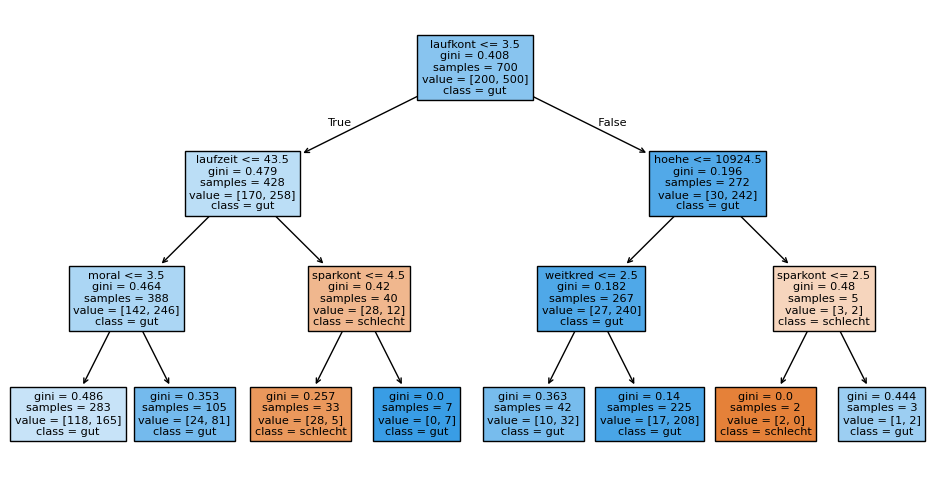

In [20]:
plt.figure(figsize=(12,6))
plot_tree(model, filled=True, feature_names=df.columns.values[1:], class_names=['schlecht','gut']);

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,1:],df.iloc[:,0],test_size=0.3, random_state=0)
model = DecisionTreeClassifier()
model.fit(X_train,y_train)
scr = model.score(X_test, y_test)
print("Die Vorhersagegenauigkeit des Entscheidungsbaumes beträgt %.3f" % scr)

Die Vorhersagegenauigkeit des Entscheidungsbaumes beträgt 0.687


Nun verwenden wir einen *Random Forrest* Klassifizierer mit einem Ensemble aus 100 Entscheidungsbaum-Instanzen.

In [22]:
from sklearn.ensemble import RandomForestClassifier

forrest = RandomForestClassifier(n_estimators=100)
forrest.fit(X_train,y_train)
scr = forrest.score(X_test, y_test)
print("Die Vorhersagegenauigkeit des Random Forests beträgt %.3f" % scr)

Die Vorhersagegenauigkeit des Random Forests beträgt 0.757
